In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform as tf
from scipy.cluster.vq import vq, kmeans, whiten
from rubik_solver import utils

In [53]:
# Define global strings for image reading
sides = ["top", "left", "front", "right", "back", "bottom"]
dataset = "2"

# Set this global flag True to see intermediate plots
plot_intermediate_results = True

In [54]:
# Find the corners of the cube in the given image
def get_corners_canny(img_name):
    img = cv2.imread(img_name, 0)
    edges = cv2.Canny(img, 300, 300)

    indices = np.where(edges != [0])
    coordinates = zip(indices[0], indices[1])
    x_list = list(indices[0])
    y_list = list(indices[1])
    x_min = min(x_list)
    y_min = min(y_list)
    x_max = max(x_list)
    y_max = max(y_list)

    x = [x_min, x_max, x_max, x_min]
    y = [y_min, y_min, y_max, y_max]

    # Plot the detected cube
    if plot_intermediate_results:
        plt.figure()
        plt.imshow(cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB))
        plt.plot(y + y[:1], x + x[:1], 'r')
        plt.title("Detected " + img_name)
        plt.show()

    return x, y

In [55]:
# Set up and compute the homography transformation

# 4 pixels per mm
f = 4
rubiks_mm = 57

# Dimensions of the face are 57 mm x 57 mm
x2 = [0, rubiks_mm*f, rubiks_mm*f, 0]
y2 = [0, 0, rubiks_mm*f, rubiks_mm*f]

def compute_homography(img_name, x, y):
    img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)

    src = np.vstack((y, x)).T
    dst = np.vstack((x2, y2)).T
    tform = tf.estimate_transform('projective', src, dst)

    return tf.warp(img, inverse_map=tform.inverse, output_shape=(rubiks_mm * f, rubiks_mm * f))

In [56]:
# Find the mean RGB color for each square
def get_face_colors(transformed_face):
    avg_sqr_colors = []
    for i in range(3):
        for j in range(3):
            top_left = (i, j)
            bottom_right = (i+1, j+1)
            block_colors = []
            for x in range(int(f * rubiks_mm * top_left[0]/3), int(f * rubiks_mm * bottom_right[0]/3)):
                for y in range(int(f * rubiks_mm * top_left[1]/3), int(f * rubiks_mm * bottom_right[1]/3)):
                    block_colors.append(transformed_face[y, x])
            avg_sqr_colors.append(255 * np.mean(block_colors, axis=0))

    return avg_sqr_colors

In [57]:
# Generate and plot the cube layout
def plot_cube_layout(all_colors, with_spaces=True):
    straight_img = np.zeros((18, 3, 3))
    for i in range(54):
        straight_img[int(i / 3), i % 3, 0] = int(all_colors[i][0])
        straight_img[int(i / 3), i % 3, 1] = int(all_colors[i][1])
        straight_img[int(i / 3), i % 3, 2] = int(all_colors[i][2])

    if with_spaces:
        s = 35
        ss = 3*s + 3 + 1
        def create_side_model(side_colors):
            side = np.zeros((ss, ss, 3))
            for i in range(3):
                for j in range(3):
                    side[(s+1)*i+1:(s+1)*i+(s+1), (s+1)*j+1:(s+1)*j+(s+1)] = side_colors[3*i + j]

            return side

        show_img = np.zeros((9*s + 9 + 1, 12*s + 12 + 1, 3))

        show_img[0:ss, ss-1:2*ss-1] = create_side_model(all_colors[0:9])
        show_img[ss-1:2*ss-1, 0:ss] = create_side_model(all_colors[9:18])
        show_img[ss-1:2*ss-1, ss-1:2*ss-1] = create_side_model(all_colors[18:27])
        show_img[ss-1:2*ss-1, 2*ss-2:3*ss-2] = create_side_model(all_colors[27:36])
        show_img[ss-1:2*ss-1, 3*ss-3:4*ss-3] = create_side_model(all_colors[36:45])
        show_img[2*ss-2:3*ss-2, ss-1:2*ss-1] = create_side_model(all_colors[45:54])

    else:
        show_img = np.zeros((9, 12, 3))

        show_img[0:3, 3:6] = straight_img[:3, :3]
        show_img[3:6, 0:3] = straight_img[3:6, :3]
        show_img[3:6, 3:6] = straight_img[6:9, :3]
        show_img[3:6, 6:9] = straight_img[9:12, :3]
        show_img[3:6, 9:12] = straight_img[12:15, :3]
        show_img[6:9, 3:6] = straight_img[15:18, :3]

    plt.figure()
    plt.imshow(np.ndarray.astype(show_img, np.uint8))
    plt.title("Cube Layout")
    plt.show()

In [58]:
# Print the instructions step-by-step to solve the cube
def print_solution_instructions(solution, face_center_labels):
    print("=" * 10)
    print("SOLUTION")
    print("=" * 10)
    for move in solution:
        f = move[0]

        # Find the top label
        if f == 'L' or f == 'F' or f == 'R' or f == 'B':
            top_label = face_center_labels[0]
        elif f == 'U':
            top_label = face_center_labels[4]
        else:
            top_label = face_center_labels[2]

        # Find the front label
        if f == 'U': front_label = face_center_labels[0]
        elif f == 'L': front_label = face_center_labels[1]
        elif f == 'F': front_label = face_center_labels[2]
        elif f == 'R': front_label = face_center_labels[3]
        elif f == 'B': front_label = face_center_labels[4]
        else: front_label = face_center_labels[5]

        # Find the direction to move
        if len(move) == 1:
            direction = "clockwise"
        elif move[1] == '\'':
            direction = "counterclockwise"
        else:
            direction = "clockwise twice"

        # Print the instructions
        print("Orient the cube so that center " + str(front_label) + " is facing you and center " + str(top_label) + " is on top")
        print("Turn the side of the cube facing you " + direction)
        input("Press the ENTER key to show the next step")
        print("=" * 10)

    print("Congratulations, you just solved the cube!")

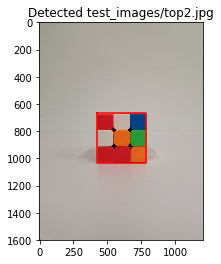

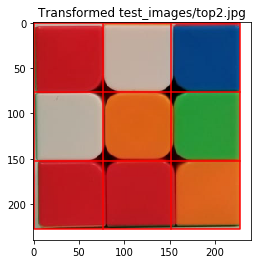

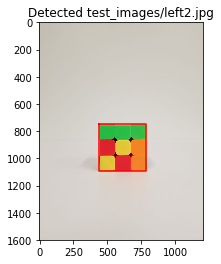

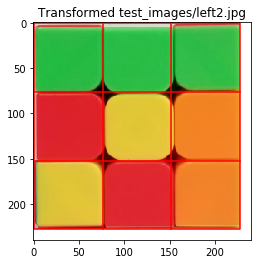

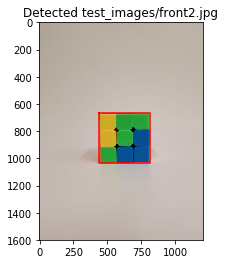

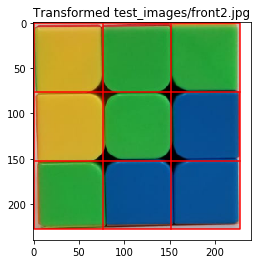

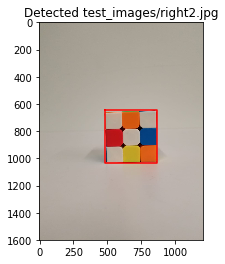

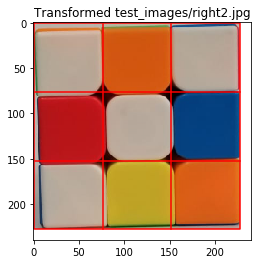

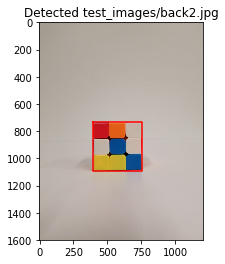

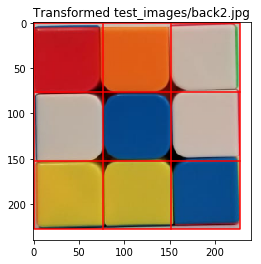

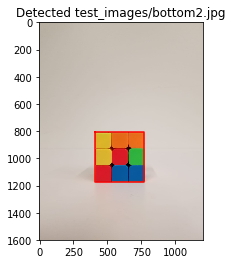

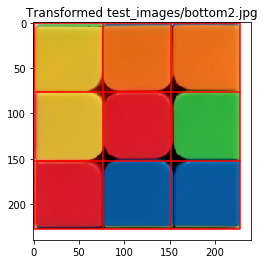

In [59]:
# Find the average RGB value for each square on the cube
all_colors = []
for side in sides:
    img_name = "test_images/" + side + dataset + ".jpg"
    x, y = get_corners_canny(img_name)
    warped = compute_homography(img_name, x, y)
    all_colors += get_face_colors(warped)

    # Plot the transformed face
    if plot_intermediate_results:
        plt.figure()
        plt.imshow(warped.transpose((1, 0, 2)))
        plt.plot(x2 + x2[:1], y2 + y2[:1], 'r-')
        plt.plot([19*f, 19*f], [1, 57*f], 'r-')
        plt.plot([38*f, 38*f], [1, 57*f], 'r-')
        plt.plot([1, 57*f], [19*f, 19*f], 'r-')
        plt.plot([1, 57*f], [38*f, 38*f], 'r-')
        plt.title("Transformed " + img_name)
        plt.show()

In [60]:
# Performs k-means clustering on the RGB values and give them
# each one of k labels, where k = 6
centers, _ = kmeans(all_colors, k_or_guess = 6)
labels = []
for color in all_colors:
    dists = []
    for center in centers:
        dists.append(np.linalg.norm(color - center))
    labels.append(np.argmin(dists))

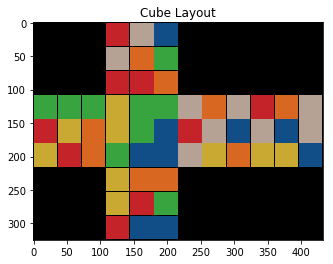

In [61]:
# Plot the Rubik's cube's faces using the cluster center as the
# representative color for each square
all_centers = [centers[label] for label in labels]
plot_cube_layout(all_centers)

In [62]:
# Assign a color to each label, consistent with the standard
# Rubik's cube color conventions
labels_to_colors = [""] * 6
labels_to_colors[labels[4]]  = "y"
labels_to_colors[labels[13]] = "b"
labels_to_colors[labels[22]] = "r"
labels_to_colors[labels[31]] = "g"
labels_to_colors[labels[40]] = "o"
labels_to_colors[labels[49]] = "w"

In [63]:
# Create the input string for the solver algorithm using the
# label to color mapping created previously
input_str = ""
for label in labels:
    input_str += labels_to_colors[label]

# Call the solving algorithm
solution = utils.solve(input_str, 'Kociemba')

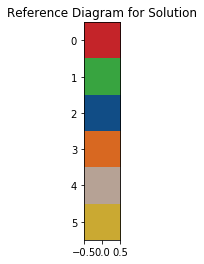

In [64]:
# Plot reference diagram
plt.figure()
ref = np.zeros((6, 1, 3))
for i in range(len(centers)):
    ref[i] = centers[i]
plt.imshow(np.ndarray.astype(ref, np.uint8))
plt.title("Reference Diagram for Solution")
plt.show(block=False)

In [69]:
# Output the solution step-by-step
face_center_labels = [labels[9*i+4] for i in range(6)]
print(solution)
solution_strs = [str(move) for move in solution]

# Uncomment this line for an interactive step-by-step solution
# print_solution_instructions(solution_strs, face_center_labels)

[B', L', U2, R', D', F, D2, L, U', F, U', L2, D, B2, U, R2, L2, D, R2, B2]
